# **Tutorial 2 SpatialEx+ Enables Larger Panel Spatial Analysis through Panel Diagonal Integration**

## Quantitative Analysis

### Step 1: [Download](https://www.10xgenomics.com/products/xenium-in-situ/human-breast-dataset-explorer) the Xenium Human Breast Cancer tissue dataset.

If you want to use the preprocessed visual representations, download the [Panel A](https://drive.google.com/file/d/1W2QBrb0AQH0f0I7sS8vsdhZmWuUozkwf/view?usp=sharing) from the first slice and [Panel B](https://drive.google.com/file/d/1PLSJM2qYs3BNbLXyGravhMooRT5YuRHH/view?usp=sharing) from the second slice.

### Step 2: Construct the following folder structure.

```
datasets/
├── Human_Breast_Cancer_Rep1/                        # The first slice
│   ├── cell_feature_matrix.h5                    
│   ├── cell.csv
|   ├── Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif          
│   ├── Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv              
│   └── Human_Breast_Cancer_Rep1_uni_resolution64_gene1.h5ad

├── Human_Breast_Cancer_Rep2/                  # The second slice
│   ├── cell_feature_matrix.h5
|   ├── cell.csv
|   ├── Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif          
│   ├── Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv             
│   └── Human_Breast_Cancer_Rep2_uni_resolution64_gene2.h5ad

├── Selection_by_name.csv
```

### Step 3: Run the following code snippet.

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import SpatialEx.preprocess as pp
from SpatialEx.utils import Compute_metrics
from SpatialEx.SpatialEx_pyG import Train_SpatialExP

#### Step 3.1 Train the model from scratch

In [ ]:
# preprocess slice 1
file_path1 = './datasets/Human_Breast_Cancer_Rep1/cell_feature_matrix.h5'
obs_path1 = './datasets/Human_Breast_Cancer_Rep1/cells.csv'
img_path1 = './datasets/Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
transform_mtx_path1 = './datasets/Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv'
resolution = 64
device = 'cuda'

# set the panel
selection = pd.read_csv('./datasets/Selection_by_name.csv', index_col=0)
panelA = selection.index[selection['slice1']].tolist()
panelB = selection.index[selection['slice2']].tolist()

adata1 = pp.Read_Xenium(file_path1, obs_path1)
adata1 = pp.Preprocess_adata(adata1, selected_genes=panelA)
img, scale = pp.Read_HE_image(img_path1)

transform_mtx = pd.read_csv(transform_mtx_path1, header=None).values
adata1 = pp.Register_physical_to_pixel(adata1, transform_mtx, scale=scale)
he_patches, adata1 = pp.Tiling_HE_patches(resolution, adata1, img)
adata1 = pp.Extract_HE_patches_representaion(he_patches, store_key='he', adata=adata1, image_encoder='uni', \
                                            device=device)
# If you would like to use our preprocessed visual features, you can apply the following code snippet.
# adata1 = sc.read_h5ad(preprocess_slice_one)

# preprocess slice 2
file_path2 = './datasets/Human_Breast_Cancer_Rep2/cell_feature_matrix.h5'
obs_path2 = './datasets/Human_Breast_Cancer_Rep2/cells.csv'
img_path2 = './datasets/Human_Breast_Cancer_Rep2/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_image.ome.tif'
transform_mtx_path2 = './datasets/Human_Breast_Cancer_Rep2/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_imagealignment.csv'

adata2 = pp.Read_Xenium(file_path2, obs_path2)
adata2 = pp.Preprocess_adata(adata2, selected_genes=panelB)
img, scale = pp.Read_HE_image(img_path2)

transform_mtx = pd.read_csv(transform_mtx_path2, header=None).values
adata2 = pp.Register_physical_to_pixel(adata2, transform_mtx, scale=scale)
he_patches, adata2 = pp.Tiling_HE_patches(resolution, adata2, img)
adata2 = pp.Extract_HE_patches_representaion(he_patches, store_key='he', adata=adata2, image_encoder='uni', \
                                            device=device)
# Similarly, if you would like to use our preprocessed visual features, you can apply the following code snippet.
# adata2 = sc.read_h5ad(preprocess_slice_two)

# use the SpatialEx+
model = Train_SpatialExP(adata1, adata2, device=device, epochs=500)
model.train()

#### Step 3.1 (Optional) Train the model with the preprocessed visual features

In [ ]:
adata1 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep1/Human_Breast_Cancer_Rep1_uni_resolution64_genes1.h5ad')
adata2 = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep2/Human_Breast_Cancer_Rep2_uni_resolution64_genes2.h5ad')

model = Train_SpatialExP(adata1, adata2, device=device, epochs=500)
model.train()

#### Step 3.2 Compute the metrics

In [ ]:
panel_1b = np.load('./results/omics1.npy')
panel_2a = np.load('./results/omics2.npy')
index_1 = adata1.obs_names
index_2 = adata2.obs_names

# build the ground truth for panelB of slice 1
adata1 = pp.Read_Xenium(file_path1, obs_path1)
adata1 = pp.Preprocess_adata(adata1, cell_mRNA_cutoff=0, selected_genes=panelB)
adata1 = adata1[index_1]

# compute the metrics for slice 1
graph = pp.Build_graph(adata1.obsm['spatial'], graph_type='knn', weighted='gaussian', \
                       apply_normalize='row', type='coo')
cs_sg, cs_reduce_sg = Compute_metrics(adata1.X, panel_1b, metric='cosine_similarity')
ssim, ssim_reduce = Compute_metrics(adata1.X, panel_1b, metric='ssim', graph=graph)
pcc, pcc_reduce = Compute_metrics(adata1.X, panel_1b, metric='pcc')
cmd, cmd_reduce = Compute_metrics(adata1.X, panel_1b, metric='cmd')
print('Evaluation of the Slice1 in gene-level, cosine similarity: ', cs_reduce_sg, \
      ' ssim: ', ssim_reduce, ' pcc: ', pcc_reduce, ' cmd: ', cmd_reduce)     

# build the ground truth for panelA of slice 2
adata2 = pp.Read_Xenium(file_path2, obs_path2)
adata2 = pp.Preprocess_adata(adata2, cell_mRNA_cutoff=0, selected_genes=panelA)
adata2 = adata2[index_2]

# compute the metrics for slice 2
graph = pp.Build_graph(adata2.obsm['spatial'], graph_type='knn', weighted='gaussian', \
                       apply_normalize='row', type='coo')
cs_sg, cs_reduce_sg = Compute_metrics(adata2.X, panel_2a, metric='cosine_similarity')
ssim, ssim_reduce = Compute_metrics(adata2.X, panel_2a, metric='ssim', graph=graph)
pcc, pcc_reduce = Compute_metrics(adata2.X, panel_2a, metric='pcc')
cmd, cmd_reduce = Compute_metrics(adata2.X, panel_2a, metric='cmd')
print('Evaluation of the Slice2 in gene-level, cosine similarity: ', cs_reduce_sg, \
      ' ssim: ', ssim_reduce, ' pcc: ', pcc_reduce, ' cmd: ', cmd_reduce)

## Qualitative Analysis

### Gene expression visualization from panel A on Slice 2 and from panel B on Slice 1

#### Step 1: Load the packages

In [1]:
import cv2
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import Estimate_boundary
import preprocess as pp 

#### Step 2: Visualize the genes

In [2]:
selection = pd.read_csv('./datasets/Selection_by_name.csv', index_col=0)
panelA = selection.index[selection['slice1']]
panelB = selection.index[selection['slice2']]

h5_path = './datasets/Human_Breast_Cancer_Rep2/cell_feature_matrix.h5'
obs_path = './datasets/Human_Breast_Cancer_Rep2/cells.csv'
img_path = './datasets/Human_Breast_Cancer_Rep2/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_image.ome.tif'
trans_mtx_path = './datasets/Human_Breast_Cancer_Rep2/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_imagealignment.csv'
ref = pp.Read_Xenium(h5_path, obs_path)    
ref = pp.Preprocess_adata(ref, cell_mRNA_cutoff=0, selected_genes=panelA)      

obs = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep2/Human_Breast_Cancer_Rep2_uni_resolution64_genes2.h5ad')

# read the output file
x_prime = pd.read_csv('./output/150_gene/ours_150_inDirect_panel2a.csv', index_col=0)
ref = ref[x_prime.index.astype(str)]
obs = obs[x_prime.index.astype(str)]
ref.obs = obs.obs.copy()
ref.obsm['image_coor'] = obs.obsm['image_coor']
x_prime = np.maximum(x_prime.values, 0)

adata = ref.copy()
adata.X = x_prime

panelA = np.load('./output/150_gene/Out_panelA2_indirect.npy')
panelA = np.maximum(panelA, 0)
obs = pd.read_csv('./datasets/Human_Breast_Cancer_Rep2/HBRC_Rep2_cell_coor.csv', index_col=0)
obs.shape
ref

/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AnnData object with n_obs × n_vars = 110947 × 150
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'image_col', 'image_row'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'log1p'
    obsm: 'spatial', 'image_coor'
    layers: 'raw'

##### Visualize the *ESR1* gene from panel A on Slice 2

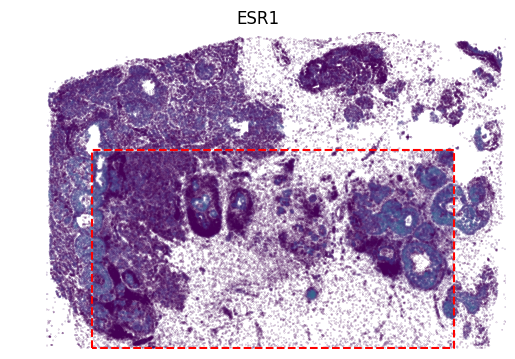

In [4]:
col_min, col_max = ref.obsm['image_coor'][:, 1].min(), ref.obsm['image_coor'][:, 1].max()
row_min, row_max = ref.obsm['image_coor'][:, 0].min(), ref.obsm['image_coor'][:, 0].max()
selection = (obs['image_row'] > row_min) & (obs['image_row'] < row_max) & (obs['image_col'] > col_min) & (obs['image_col'] < col_max)
obs_inner = obs[selection]
var_names = adata.var_names
# draw the predicted spatial expression within the sequencing area
value = adata[:, 'ESR1'].X
vmax = ref[:, 'ESR1'].X.max()

x, y = ref.obsm['image_coor'][:, 0], ref.obsm['image_coor'][:, 1]
plt.scatter(x, y, c=value, vmax=vmax-0.8, s=0.01)

# draw red box
x = [row_min, row_min, row_max, row_max, row_min]
y = [col_min, col_max, col_max, col_min, col_min]
plt.plot(x, y, color='red', linestyle='--')

# draw the predicted spatial expression out of the sequencing area
gene_idx = np.where(var_names=='ESR1')[0].item()
value = panelA[:, gene_idx]
x, y = obs['image_col'], obs['image_row']
plt.scatter(y[~selection], x[~selection], c=value[~selection], s=0.01, vmin=0, vmax=vmax-0.8)

plt.title('ESR1')
plt.ylim((0,x.max()))
plt.xlim((0,y.max()))
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)

##### Visualize the ERBB2 gene from panel A on Slice 2

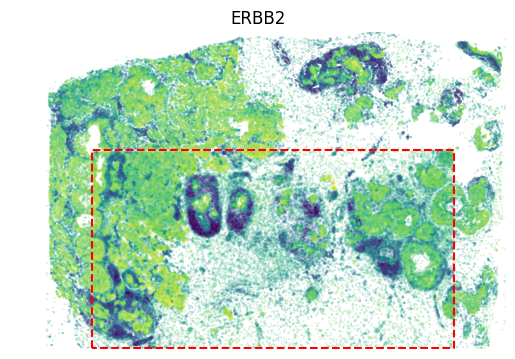

In [57]:
# draw the predicted spatial expression within the sequencing area
value = adata[:, 'ERBB2'].X
vmax = ref[:, 'ERBB2'].X.max()

x, y = ref.obsm['image_coor'][:, 0], ref.obsm['image_coor'][:, 1]
plt.scatter(x, y, c=value, vmax=vmax-0.8, s=0.01)

# draw red box
x = [row_min, row_min, row_max, row_max, row_min]
y = [col_min, col_max, col_max, col_min, col_min]
plt.plot(x, y, color='red', linestyle='--')

# draw the predicted spatial expression out of the sequencing area
gene_idx = np.where(var_names=='ERBB2')[0].item()
value = panelA[:, gene_idx]
x, y = obs['image_col'], obs['image_row']
plt.scatter(y[~selection], x[~selection], c=value[~selection], s=0.01, vmin=0, vmax=vmax-0.8)

plt.title('ERBB2')
plt.ylim((0,x.max()))
plt.xlim((0,y.max()))
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)

##### Visualize *PGR* gene from panel B on Slice 1

In [5]:
h5_path = './datasets/Human_Breast_Cancer_Rep1/cell_feature_matrix.h5'
obs_path = './datasets/Human_Breast_Cancer_Rep1/cells.csv'
img_path = './datasets/Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
trans_mtx_path = './datasets/Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv'
ref = pp.Read_Xenium(h5_path, obs_path)    
ref = pp.Preprocess_adata(ref, cell_mRNA_cutoff=0, selected_genes=panelB)      

obs = sc.read_h5ad('./datasets/Human_Breast_Cancer_Rep1/Human_Breast_Cancer_Rep1_uni_resolution64_genes1.h5ad')

# read the output file
x_prime = pd.read_csv('./output/150_gene/ours_150_inDirect_panel1b.csv', index_col=0)
ref = ref[x_prime.index.astype(str)]
obs = obs[x_prime.index.astype(str)]
ref.obs = obs.obs.copy()
ref.obsm['image_coor'] = obs.obsm['image_coor']
x_prime = np.maximum(x_prime.values, 0)

adata = ref.copy()
adata.X = x_prime

panelA = np.load('./output/150_gene/Out_panelB1_indirect.npy')
panelA = np.maximum(panelA, 0)
obs = pd.read_csv('./datasets/Human_Breast_Cancer_Rep1/HBRC_Rep1_cell_coor.csv', index_col=0)
obs.shape
ref

/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AnnData object with n_obs × n_vars = 161542 × 163
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'image_col', 'image_row'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'log1p'
    obsm: 'spatial', 'image_coor'
    layers: 'raw'

(1093.75, 30469.25, 1514.15, 23268.85)

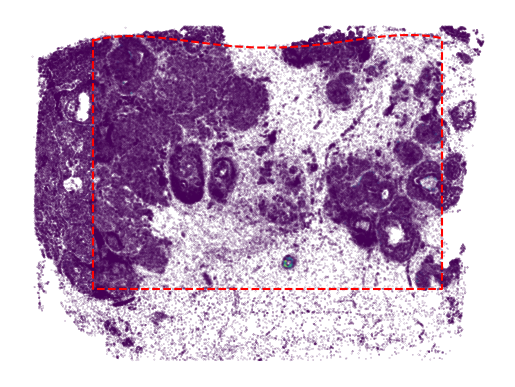

In [27]:
out_values = np.load('./output/150_gene/Out_panelB1_indirect.npy')
out_values = np.maximum(out_values, 0)
inner = pd.read_csv('./output/150_gene/ours_150_inDirect_panel1b.csv', index_col=0)
adata = adata[inner.index.astype(str)]
inner = np.maximum(inner.values, 0)


gene_name = 'PGR'
gene_idx = np.where(np.array(panelB) == gene_name)[0]
vmax = ref[:, gene_name].X.max()
value = out_values[:, gene_idx].squeeze()
x = np.arange(innerx.min(), innerx.max())
y_boundary = boundary_func(x) - 100

plt.plot(x, y_boundary, color='red', linestyle='--')
plt.plot([innerx.min(), innerx.min(), innerx.max(), innerx.max()], [innery.max()-300, innery.min(), innery.min(), innery.max()-225],
         color='red', linestyle='--')

plt.scatter(outx[selection], outy[selection], c=value[selection], vmin=0, vmax=vmax-0.1, s=0.012)
value = inner[:, gene_idx]
plt.scatter(innerx, innery, c=value, vmin=0.1, s=0.008)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')

##### Visualize *KRT14* gene from panel B on Slice 1

(1093.75, 30469.25, 1514.15, 23268.85)

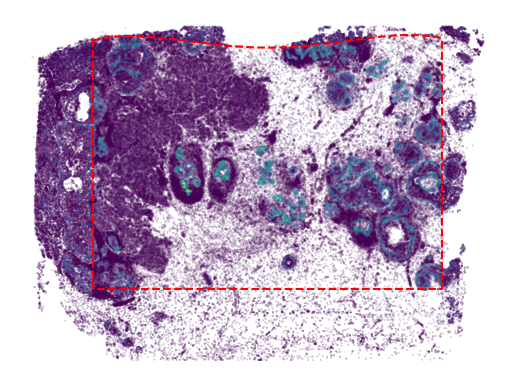

In [28]:
gene_name = 'KRT14'
gene_idx = np.where(np.array(panelB) == gene_name)[0]
vmax = ref[:, gene_name].X.max()
value = out_values[:, gene_idx].squeeze()
x = np.arange(innerx.min(), innerx.max())
y_boundary = boundary_func(x) - 100

plt.plot(x, y_boundary, color='red', linestyle='--')
plt.plot([innerx.min(), innerx.min(), innerx.max(), innerx.max()], [innery.max()-300, innery.min(), innery.min(), innery.max()-225],
         color='red', linestyle='--')

plt.scatter(outx[selection], outy[selection], c=value[selection], vmin=0, vmax=vmax-0.1, s=0.012)
value = inner[:, gene_idx]
plt.scatter(innerx, innery, c=value, vmin=0.1, s=0.008)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')

## The role of SpatialEx+ panel expansion

### Step 1: Load the packages

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

### Step 2: Define the color

In [2]:
color_dict = {'Stromal':'#6b6ecf', 'Invasive_Tumor':'#f7b6d2', 'DCIS_1':'#7b4173', 'DCIS_2':'#d6616b', 
              'Endothelial':'#c49c94', 'Macrophages_1':'#ff7f0e', 'Macrophages_2':'#ffbb78',
             'Myoepi_ACTA2+':'#EEDD82', 'Myoepi_KRT15+':'#FFD700', 'B_Cells':'#66CD00', 'CD8+_T_Cells':'#9ACD32', 
             'CD4+_T_Cells':'#B3EE3A', 'Prolif_Invasive_Tumor':'#CD3278',
             'Perivascular-Like':'#aa40fc', 'LAMP3+_DCs':'#1f77b4',
             'IRF7+_DCs':'#17becf', 'Mast_Cells':'#279e68'}
values = list(color_dict.values())
color_dict = dict(zip(np.arange(len(values)), values))
color_dict = {0: '#6b6ecf',
 2: '#f7b6d2',
 7: '#7b4173',
 1: '#d6616b',
 9: '#c49c94',
 5: '#ff7f0e',
 10: '#ffbb78',
 15: '#EEDD82',
 8: '#FFD700',
 11: '#66CD00',
 6: '#9ACD32',
 12: '#B3EE3A',
 4: '#CD3278',
 13: '#aa40fc',
 3: '#6699FF',
 14: '#17becf',
 16: '#279e68'}

### Step 3: Visualize the spatial domain

In [3]:
adata = sc.read_h5ad('./output/cellcharter/Human_Breast_Cancer_Outlier_2slice_250+163.h5ad')
obs = pd.read_csv('./datasets/Human_Breast_Cancer_Rep1/HBRC_Rep1_cell_coor.csv', index_col=0)
rep1 = adata[:obs.shape[0]]
rep2 = adata[obs.shape[0]:]
adata

AnnData object with n_obs × n_vars = 322080 × 313
    obs: 'CellCharter_cluster10', 'CellCharter_cluster11', 'CellCharter_cluster12', 'CellCharter_cluster13', 'CellCharter_cluster14', 'CellCharter_cluster15', 'CellCharter_cluster16', 'CellCharter_cluster17', 'CellCharter_cluster18', 'CellCharter_cluster19', 'CellCharter_cluster20', 'CellCharter_cluster21', 'cluster_cellcharter'
    uns: 'spatial_neighbors'
    obsm: 'X_cellcharter', 'X_scVI', 'spatial'
    obsp: 'spatial_connectivities'

Slice 1

/tmp/ipykernel_890757/4116428783.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rep1.obs['CellCharter_cluster11'] = rep1.obs['CellCharter_cluster11'].astype('category')


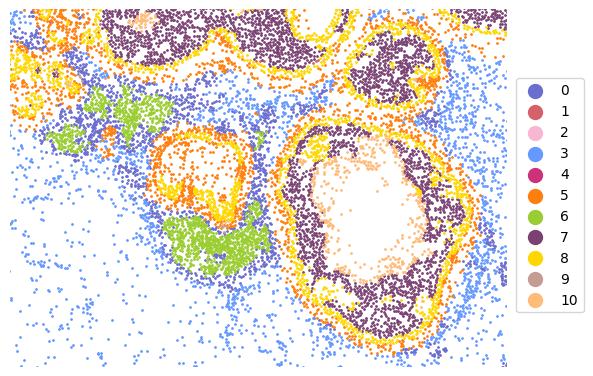

In [4]:
rep1.obs['CellCharter_cluster11'] = rep1.obs['CellCharter_cluster11'].astype('category')
x, y = rep1.obsm['spatial'][:, 0], rep1.obsm['spatial'][:, 1]
ct_list = list(color_dict.keys())
celltype = rep1.obs['CellCharter_cluster11'].values
for i in range(11):
    selection = (celltype == i)
    plt.scatter(x[selection], y[selection], c=color_dict[i], s=1, label=i)
plt.legend(bbox_to_anchor=(1.02, 0.15), loc=3, borderaxespad=0, markerscale=10)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')
plt.ylim(8200, 12300)
plt.xlim(19800, 25500)

Slice 2

/tmp/ipykernel_895442/4108358639.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rep2.obs['CellCharter_cluster11'] = rep2.obs['CellCharter_cluster11'].astype('category')


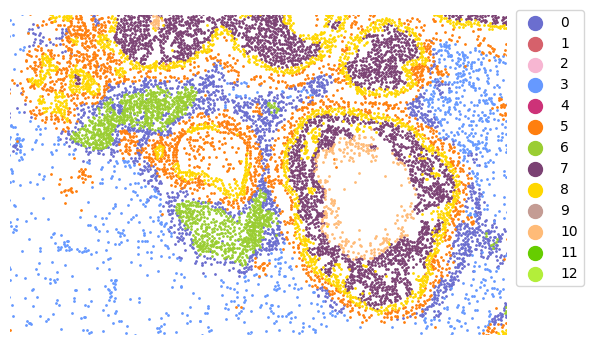

In [4]:
rep2.obs['CellCharter_cluster11'] = rep2.obs['CellCharter_cluster11'].astype('category')
x, y = rep2.obsm['spatial'][:, 0], rep2.obsm['spatial'][:, 1]
ct_list = list(color_dict.keys())
celltype = rep2.obs['CellCharter_cluster11'].values
for i in range(13):
    selection = (celltype == i)
    plt.scatter(y[selection], x[selection], c=color_dict[i], s=1, label=i)
plt.legend(bbox_to_anchor=(1.02, 0.15), loc=3, borderaxespad=0, markerscale=10)
ax = plt.gca()
ax.set_aspect(1)
plt.xlim(79000, 85300)
plt.ylim(63200, 67250)
plt.axis('off')